# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.8.0


# Загружаем разметку

In [25]:
import os
import json
from glob import glob

TRAIN_PREFIX = 'E:/fish/train'

def load_annotations():
    boxes = dict()
    for path in glob('E:/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [26]:
boxes = load_annotations()  # загружаем разметку детекций


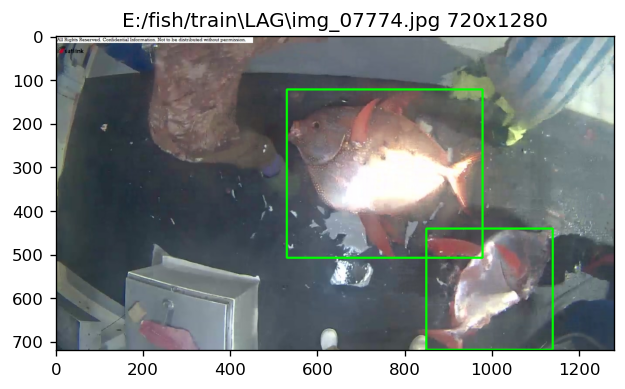

In [27]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

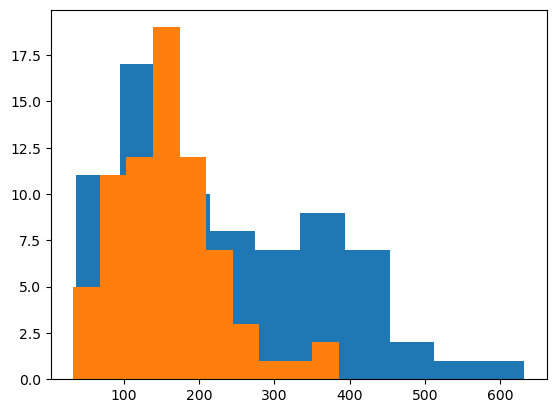

In [5]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [6]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [7]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [8]:
class_mapping = {cls: idx for idx, cls in enumerate(sorted(boxes.keys()))}
num_classes = len(class_mapping)

In [9]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 5), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh]
            
    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

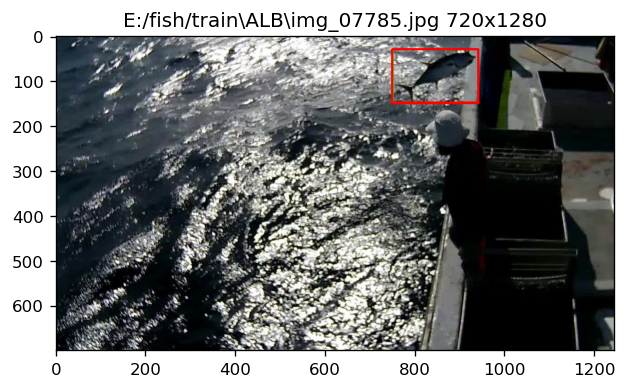

In [10]:
annotation = boxes['alb'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [11]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss

## Загрузка данных

In [12]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            yield np.array(X), np.array(y)

## Модифицируем ф-и потерь

In [13]:
def classification_loss(y_true, y_pred):
    # Классы идут начиная с 5-го канала (bbox: 4 + conf: 1)
    class_true = y_true[..., 5:]  
    class_pred = y_pred[..., 5:]
    
    # Преобразуем логиты в вероятности
    class_pred_probs = tf.nn.softmax(class_pred)
    return K.categorical_crossentropy(class_true, class_pred_probs)

def confidence_loss(y_true, y_pred):
    return K.binary_crossentropy(y_true[..., 0], y_pred[..., 0], from_logits=True)

def smooth_l1(y_true, y_pred):
    bbox_true = y_true[..., 1:5]  # Координаты бокса
    bbox_pred = y_pred[..., 1:5]  # Координаты бокса
    abs_loss = K.abs(bbox_true - bbox_pred)
    square_loss = 0.5 * K.square(bbox_true - bbox_pred)
    mask = K.cast(K.greater(abs_loss, 1.0), 'float32')
    return K.sum(mask * (abs_loss - 0.5) + (1.0 - mask) * square_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3, loc_weight=1.0, class_weight=1.0):
    batch_size = K.shape(y_true)[0]

    y_true = K.reshape(y_true, (batch_size, -1, K.shape(y_true)[-1]))
    y_pred = K.reshape(y_pred, (batch_size, -1, K.shape(y_pred)[-1]))

    conf_loss = confidence_loss(y_true, y_pred)

    loc_loss = smooth_l1(y_true, y_pred)

    class_loss = classification_loss(y_true, y_pred)

    pos_mask = K.cast(y_true[..., 0], dtype='float32')  # Приведение к float32
    pos_conf_loss = K.sum(conf_loss * pos_mask, axis=-1)
    pos_loc_loss = K.sum(loc_loss * pos_mask, axis=-1)
    pos_class_loss = K.sum(class_loss * pos_mask, axis=-1)

    anchors = K.shape(y_true)[1]
    num_pos = K.sum(pos_mask, axis=-1)
    num_neg = K.minimum(neg_pos_ratio * K.maximum(num_pos, 1), tf.cast(anchors, 'float32'))  # Приведение к float32

    num_neg_scalar = tf.reduce_mean(num_neg)

    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1.0 - pos_mask), k=tf.cast(num_neg_scalar, 'int32'))
    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)

    total_conf_loss = (pos_conf_loss + neg_conf_loss) / (num_pos + num_neg_scalar + 1e-8)
    total_loc_loss = pos_loc_loss / (num_pos + 1e-8)
    total_class_loss = pos_class_loss / (num_pos + 1e-8)

    tf.print("Conf Loss:", total_conf_loss, "Loc Loss:", total_loc_loss, "Class Loss:", total_class_loss)

    total_loss_val = total_conf_loss + loc_weight * total_loc_loss + class_weight * total_class_loss

    return total_loss_val



## Проверяем ф-и потерь

In [14]:
# Тестовые данные для проверки
batch_size = 2
num_anchors = 10
num_classes = 6

# Генерация фейковых данных (y_true и y_pred)
y_true = np.zeros((batch_size, num_anchors, 5 + num_classes))
y_pred = np.random.random((batch_size, num_anchors, 5 + num_classes))

# Установка фейковых значений для положительных примеров
y_true[:, :5, 0] = 1  # Уверенность

y_true[:, :5, 1:5] = np.random.random((batch_size, 5, 4))  # bbox координаты

y_true[:, :5, 5:] = np.eye(num_classes)[np.random.choice(num_classes, 5)]  # классы в one-hot

# Преобразование в тензоры
y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.float32)
y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.float32)

# Тесты функций потерь
def test_loss_functions():
    print("\nПроверка confidence_loss")
    conf_loss = confidence_loss(y_true_tensor, y_pred_tensor)
    print("confidence_loss успешно выполнена. Форма:", conf_loss.shape)

    print("\nПроверка smooth_l1")
    loc_loss = smooth_l1(y_true_tensor, y_pred_tensor)
    print("smooth_l1 успешно выполнена. Форма:", loc_loss.shape)

    print("\nПроверка classification_loss")
    class_loss = classification_loss(y_true_tensor, y_pred_tensor)
    print("classification_loss успешно выполнена. Форма:", class_loss.shape)

    print("\nПроверка total_loss")
    total_loss_val = total_loss(y_true_tensor, y_pred_tensor)
    print("total_loss успешно выполнена. Значение:", total_loss_val)

test_loss_functions()


Проверка confidence_loss
confidence_loss успешно выполнена. Форма: (2, 10)

Проверка smooth_l1
smooth_l1 успешно выполнена. Форма: (2, 10)

Проверка classification_loss
classification_loss успешно выполнена. Форма: (2, 10)

Проверка total_loss
Conf Loss: [0.494315714 0.452156961] Loc Loss: [0.382979333 0.239814162] Class Loss: [1.65429628 1.84304488]
total_loss успешно выполнена. Значение: tf.Tensor([2.5315914 2.535016 ], shape=(2,), dtype=float32)


## Модифицируем ф-ю iou

In [15]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    # Координаты прямоугольника
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    # Координаты якоря
    anch_x1 = anchor_x - anchor_w / 2
    anch_x2 = anchor_x + anchor_w / 2
    anch_y1 = anchor_y - anchor_h / 2
    anch_y2 = anchor_y + anchor_h / 2
    
    # Пересечение
    dx = max(0, min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = max(0, min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    intersection = dx * dy
    
    # Площади прямоугольников
    rect_area = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    anch_area = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    
    # Объединение
    union = rect_area + anch_area - intersection
    
    # IoU
    return intersection / union if union > 0 else 0.0

## Модифицируем ф-ю encode

In [16]:
def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0], FEATURE_SHAPE[1], 5 + 6), dtype=np.float32)

    x_scale = 1.0 * IMG_WIDTH / img_shape[1]
    y_scale = 1.0 * IMG_HEIGHT / img_shape[0]

    for box in annotation['annotations']:
        class_id = class_mapping.get(box['class'], 0)
        scores = []

        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(box, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # Default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - box['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - box['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - box['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - box['height'] * y_scale) / ANCHOR_HEIGHT

            # Добавляем one-hot векторы для классов
            one_hot = np.zeros(6, dtype=np.float32)
            one_hot[class_id] = 1.0

            encoded[row, col] = [1.0, dx, dy, dw, dh] + one_hot.tolist()
    
    return encoded


## Модифицируем ф-ю dencode и non_max_suppression

In [17]:
def decode_prediction(prediction, img_shape, conf_thr=0.5):
    """
    Декодирует предсказания с дополнительным исправлением порядка координат.
    """
    decoded_boxes = []
    for row in range(prediction.shape[0]):
        for col in range(prediction.shape[1]):
            logit, dx, dy, dw, dh, *one_hot = prediction[row, col]
            
            conf = _sigmoid(logit)
            if conf > conf_thr:
                class_id = np.argmax(one_hot)

                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]

                # Преобразование в координаты x_min, y_min, x_max, y_max
                x_center = anchor_x + dx * ANCHOR_WIDTH
                y_center = anchor_y + dy * ANCHOR_HEIGHT
                width = abs(dw) * ANCHOR_WIDTH  # Исправление: берём модуль ширины
                height = abs(dh) * ANCHOR_HEIGHT  # Исправление: берём модуль высоты

                x1 = min(x_center - width / 2, x_center + width / 2)
                y1 = min(y_center - height / 2, y_center + height / 2)
                x2 = max(x_center - width / 2, x_center + width / 2)
                y2 = max(y_center - height / 2, y_center + height / 2)

                # Масштабирование к изображению
                x1 /= IMG_WIDTH / img_shape[1]
                y1 /= IMG_HEIGHT / img_shape[0]
                x2 /= IMG_WIDTH / img_shape[1]
                y2 /= IMG_HEIGHT / img_shape[0]

                # Отладочный вывод
                print(f"Fixed box: ({x1:.2f}, {y1:.2f}, {x2:.2f}, {y2:.2f}), conf: {conf:.2f}")

                decoded_boxes.append({
                    'bbox': [x1, y1, x2, y2],
                    'class': class_id,
                    'conf': conf
                })
    return decoded_boxes

def non_max_suppression(rectangles, max_output_size=5, iou_threshold=0.1):
    if not rectangles:
        return rectangles

    boxes = [r['bbox'] for r in rectangles]
    scores = [r['conf'] for r in rectangles]

    indices = tf.image.non_max_suppression(
        boxes=np.array(boxes),
        scores=np.array(scores),
        max_output_size=max_output_size,
        iou_threshold=iou_threshold
    )

    filtered_rectangles = [rectangles[i] for i in indices.numpy()]

    return filtered_rectangles


## Модифицируем ф-ю data_generator

In [33]:
def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    
    while True:
        shuffle(boxes)  # Перемешиваем аннотации перед каждой эпохой
        for i in range(len(boxes) // batch_size):
            X, y = [], []
            for j in range(i * batch_size, (i + 1) * batch_size):
                # Загружаем изображение и его форму
                img_shape, img = load_img(boxes[j]['filename'])
                
                # Кодируем аннотации с использованием функции encode_anchors
                anchors = encode_anchors(boxes[j], img_shape)
                
                X.append(img)     # Добавляем изображение
                y.append(anchors) # Добавляем закодированные аннотации
            
            # Преобразуем списки в numpy массивы
            yield np.array(X), np.array(y)


## Проверяем корректность измененных ф-й

In [41]:
def test_functions():
    batch_size = 2
    generator = data_generator(boxes, batch_size=batch_size)
    X_batch, y_batch = next(generator)

    # Проверяем размерности выходов генератора
    assert X_batch.shape == (batch_size, IMG_HEIGHT, IMG_WIDTH, 3), "Неверная форма изображений в батче"
    assert y_batch.shape == (batch_size, FEATURE_SHAPE[0], FEATURE_SHAPE[1], 11), "Неверная форма аннотаций в батче"

    print("data_generator: работает корректно")

    first_class_key = list(boxes.keys())[0]  # Ключ первого класса (например, 'alb')
    first_annotation = boxes[first_class_key][0]  # Первая аннотация в этом классе

    img_shape, _ = load_img(first_annotation['filename'])  # Загружаем изображение
    encoded_anchors = encode_anchors(first_annotation, img_shape)  # Кодируем аннотации

    # Проверяем размерность закодированных аннотаций
    assert encoded_anchors.shape == (FEATURE_SHAPE[0], FEATURE_SHAPE[1], 11), \
        "Неверная размерность закодированных аннотаций"

    print("encode_anchors: работает корректно")

    encoded_prediction = y_batch[0]
    img_shape = (IMG_HEIGHT, IMG_WIDTH)

    decoded_predictions = decode_prediction(encoded_prediction, img_shape, conf_thr=0.5)

    print("Содержимое decoded_predictions:", decoded_predictions)

    assert isinstance(decoded_predictions, list), "Декодированные предсказания должны быть списком"

    if decoded_predictions:
        first_pred = decoded_predictions[0]
        assert isinstance(first_pred, dict), "Каждое предсказание должно быть словарем"
        assert 'conf' in first_pred, "В предсказании отсутствует ключ 'conf'"
        assert 'class' in first_pred, "В предсказании отсутствует ключ 'class'"
        assert 'bbox' in first_pred, "В предсказании отсутствует ключ 'bbox'"
        assert len(first_pred['bbox']) == 4, "Координаты 'bbox' должны содержать 4 значения"

    print(f"decode_prediction: успешно декодировало {len(decoded_predictions)} объектов")

    print("decode_prediction: работает корректно")

test_functions()


data_generator: работает корректно
encode_anchors: работает корректно
Fixed box: (815.01, 365.59, 834.14, 463.81), conf: 0.73
Fixed box: (815.01, 430.81, 834.14, 529.03), conf: 0.73
Fixed box: (815.01, 496.02, 834.14, 594.24), conf: 0.73
Fixed box: (815.01, 561.24, 834.14, 659.46), conf: 0.73
Содержимое decoded_predictions: [{'bbox': [815.0103045602305, 365.58967627908874, 834.1446785231096, 463.8084242525308], 'class': 0, 'conf': 0.7310585896677003}, {'bbox': [815.0103045602305, 430.8070665144402, 834.1446785231096, 529.0258144878823], 'class': 0, 'conf': 0.7310585896677003}, {'bbox': [815.0103045602305, 496.0244573085853, 834.1446785231096, 594.2432052820274], 'class': 0, 'conf': 0.7310585896677003}, {'bbox': [815.0103045602305, 561.2418492203174, 834.1446785231096, 659.4605971937594], 'class': 0, 'conf': 0.7310585896677003}]
decode_prediction: успешно декодировало 4 объектов
decode_prediction: работает корректно


## Модифицируем ф-ю draw_boxes

In [29]:
def draw_boxes(annotation, rectangles=None, image_size=None):
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            bbox = rect.get('bbox', [0, 0, 0, 0])
            x_min, y_min, x_max, y_max = bbox
            
            pt1 = (int(x_min * scale_x), int(y_min * scale_y))
            pt2 = (int(x_max * scale_x), int(y_max * scale_y))
            
            img = cv2.rectangle(img.copy(), pt1, pt2, color=color, thickness=4)
            if 'class' in rect and 'conf' in rect:
                label = f"{rect['class']} ({rect['conf']:.2f})"
                font_scale = 0.8
                thickness = 2
                label_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
                label_pt1 = (pt1[0], pt1[1] - label_size[1] - baseline)
                label_pt2 = (pt1[0] + label_size[0], pt1[1])
                cv2.rectangle(img, label_pt1, label_pt2, (0, 0, 255), -1)
                cv2.putText(img, label, (pt1[0], pt1[1] - baseline), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)
        return img
    scale_x, scale_y = 1.0, 1.0
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[..., ::-1]
    if image_size is not None:
        scale_x = 1.0 * image_size[0] / img.shape[1]
        scale_y = 1.0 * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
    
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)

    if rectangles is not None:
        img = _draw(img, rectangles, scale_x, scale_y, color=(255, 0, 0))

    return img

## Добавляем выход детектора

In [35]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)


output_cls = tf.keras.layers.Conv2D(6,
                                    kernel_size=(1, 1),
                                    activation='softmax',
                                    kernel_regularizer='l2')(feature_tensor)
model = tf.keras.models.Model(inputs=features.inputs, outputs=[output, output_cls])
    
output = tf.keras.layers.Conv2D(11,
                                kernel_size=(1, 1), 
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)

adam = tf.keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[confidence_loss])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 750, 1200, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 750, 1200, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 750, 1200, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 375, 600, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 375, 600, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 375, 600, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 187, 300, 128)     0   

                                                                 
 block3_pool (MaxPooling2D)  (None, 93, 150, 256)      0         
                                                                 
 block4_conv1 (Conv2D)       (None, 93, 150, 512)      1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 93, 150, 512)      2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 93, 150, 512)      2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 46, 75, 512)       0         
                                                                 
 block5_conv1 (Conv2D)       (None, 46, 75, 512)       2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 46, 75, 512)       2359808   
                                                                 
 block5_co

e:\Anaconda\envs\gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Обучение

In [43]:
batch_size = 5

gen = data_generator(
    boxes=boxes,
    batch_size=batch_size
)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          callbacks=[checkpoint])

Epoch 1/100
Conf Loss: [0.458548844 0.504887521 0.505623043 0.516263127 0.496552557] Loc Loss: [0.0903419852 0.0333395116 0.0268443171 0.0372096635 0.037946187] Class Loss: [0.000234875843 0.00584194111 0.00173263566 0.00437683286 0.000708418142]
 9/10 [========================>.....] - ETA: 0s - loss: 0.7786 - confidence_loss: 0.4885Conf Loss: [0.495762795 0.519241154 0.458114654 0.500527501 0.543989778] Loc Loss: [0.0586617477 0.018555861 0.071502611 0.0624480024 0.043197941] Class Loss: [0.00273840665 0.0160653219 0.00126525364 0.00350028882 0.00506582]

Epoch 1: loss improved from inf to 0.77507, saving model to fishdetector.hdf5
10/10 [==============================] - 3s 307ms/step - loss: 0.7746 - confidence_loss: 0.4863
Epoch 2/100
Conf Loss: [0.505426705 0.565428615 0.533637643 0.550124705 0.515772641] Loc Loss: [0.0386006199 0.0112995338 0.052723255 0.0143828755 0.0479784124] Class Loss: [0.00272715 0.0108358553 0.00161279249 0.000884618377 0.00121674396]
 8/10 [=============

## Результат работы детектора

In [22]:
# model.load_weights('E:/fish/fishdetector_weights.hdf5')

Fixed box: (-3609.38, -2631.91, -1476.76, -1455.00), conf: 0.30
Fixed box: (-3358.75, -2483.60, -1346.67, -1385.09), conf: 0.27
Fixed box: (-3222.16, -2435.75, -1299.84, -1340.99), conf: 0.33
Fixed box: (-3001.76, -2306.08, -1147.06, -1255.65), conf: 0.36
Fixed box: (-2878.36, -2201.85, -1067.92, -1187.90), conf: 0.33
Fixed box: (-2795.14, -2168.74, -1016.38, -1177.77), conf: 0.29
Fixed box: (-2651.06, -2152.25, -921.05, -1199.43), conf: 0.28
Fixed box: (-2697.95, -2232.14, -928.64, -1256.48), conf: 0.27
Fixed box: (-2666.50, -2233.30, -884.77, -1255.00), conf: 0.27
Fixed box: (-2441.56, -2088.29, -734.37, -1208.26), conf: 0.26
Fixed box: (-1932.47, -1680.34, -440.96, -983.31), conf: 0.26
Fixed box: (209.82, -59.84, 440.37, -55.18), conf: 0.34
Fixed box: (492.71, -0.55, 516.16, 9.14), conf: 0.41
Fixed box: (550.55, -6.71, 564.56, -2.48), conf: 0.40
Fixed box: (588.97, -17.25, 614.12, -16.21), conf: 0.40
Fixed box: (614.77, -37.45, 656.27, -24.28), conf: 0.40
Fixed box: (638.85, -32.42,

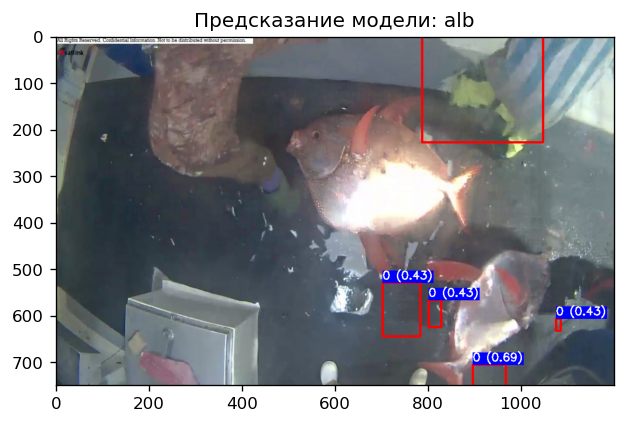

In [ ]:
annotation = boxes['lag'][0]
_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], (IMG_HEIGHT, IMG_WIDTH), conf_thr=0.2)
decoded = non_max_suppression(decoded, max_output_size=5, iou_threshold=0.1)

# Получаем первый предсказанный класс, если он есть
predicted_class_value = decoded[0].get('class', 'unknown') if decoded else 'unknown'
predicted_class = next((key for key, value in class_mapping.items() if value == predicted_class_value), 'unknown')

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)

plt.title(f"Предсказание модели: {predicted_class}")
plt.show()

## Визуализируем предсказание на тесте

Fixed box: (-210.48, 1232.86, 322.54, 1414.63), conf: 0.04
Fixed box: (-506.04, 289.89, 299.54, 539.40), conf: 0.03
Fixed box: (-395.35, 320.80, 296.99, 511.49), conf: 0.03
Fixed box: (-383.29, 322.01, 366.71, 553.09), conf: 0.03
Fixed box: (-352.95, 311.71, 419.20, 561.16), conf: 0.03
Fixed box: (-275.12, 299.35, 456.58, 538.50), conf: 0.03
Fixed box: (-237.09, 373.92, 475.94, 586.73), conf: 0.03
Fixed box: (-204.84, 387.86, 507.22, 591.05), conf: 0.03
Fixed box: (-195.18, 422.61, 537.94, 640.63), conf: 0.03
Fixed box: (-171.51, 444.83, 559.77, 638.49), conf: 0.02
Fixed box: (-42.12, 360.30, 645.01, 513.24), conf: 0.02
Fixed box: (7.05, 355.48, 565.76, 549.00), conf: 0.03
Fixed box: (82.26, 243.25, 503.13, 475.23), conf: 0.03
Fixed box: (333.59, -44.29, 535.33, 124.80), conf: 0.05
Fixed box: (423.12, 18.53, 492.24, 71.10), conf: 0.04
Fixed box: (516.95, 60.44, 560.73, 112.61), conf: 0.04
Fixed box: (525.77, 83.35, 576.85, 98.29), conf: 0.05
Fixed box: (533.77, 78.29, 590.49, 98.71), c

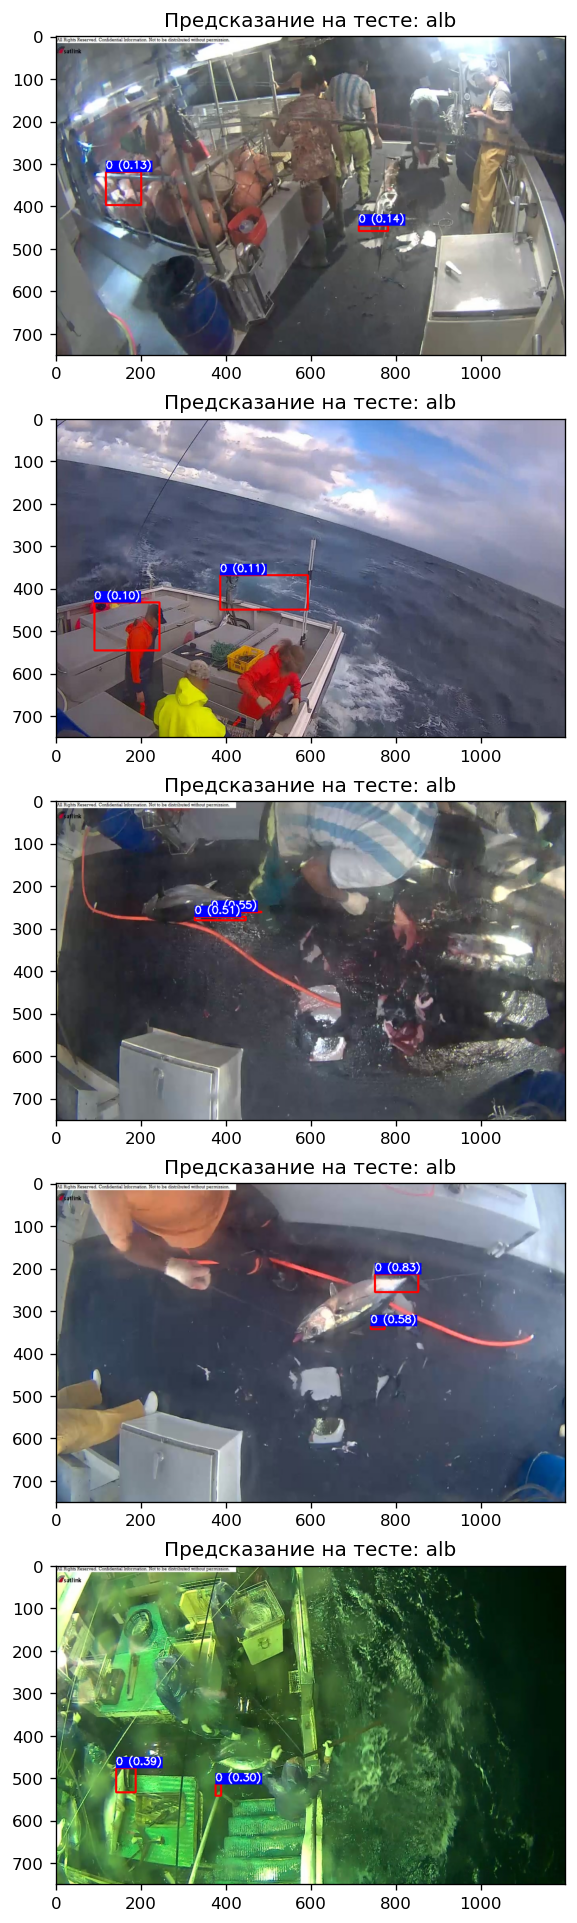

In [24]:
test_images = glob('E:/fish/test_stg1/*.jpg')[:5]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], (IMG_HEIGHT, IMG_WIDTH), conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
    
    # Получаем первый предсказанный класс, если он есть
    predicted_class_value = decoded[0].get('class', 'unknown') if decoded else 'unknown'
    predicted_class = next((key for key, value in class_mapping.items() if value == predicted_class_value), 'unknown')
    
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title(f"Предсказание на тесте: {predicted_class}");